IS6400 21/22 Semester B

- Week 8: Time Series (II)
    - AutoRegression models
    
Zhiya Zuo (zhiyazuo@cityu.edu.hk)

Department of Information Systems

City University of Hong Kong

---

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as SP_STATS

In [3]:
from sklearn import metrics
import statsmodels.api as sm

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
# if running in Google Colab, please run the following line
# !pip install --upgrade statsmodels

---

# The question

Use the data `EGY_Exports.csv` (collected from [link](https://rdrr.io/cran/tsibbledata/man/global_economy.html)) for the following analysis:
1. Is this time series stationary?
    - Start with a graphical approach
    - Use the KPSS test to quantitatively verify your visual inspection.
1. Discuss the pattern of trend or seasonality using (partial) autocorrelation diagram.
1. Split the data in a 80%-20% fashion for training-testing and then:
    - Train an AR model. How do you decide the order?
    - Train an ARIMA model with constant trend. How do you specify this model?
    - Also use the exponential smoothing method. Which model do you want?
    - Compare the performance on both the training and testing set.

---

# Data and visualizastion

In [8]:
#egy = pd.read_csv('../Data/EGY_Exports.csv', index_col='Year', squeeze=True)
url = 'https://raw.githubusercontent.com/zhiyzuo/IS6400-Regression/main/Data/EGY_Exports.csv'
egy = pd.read_csv(url, index_col='Year', squeeze=True)
egy.index = pd.to_datetime(egy.index, format='%Y')

In [9]:
# resample to create frequency-based series data
egy = egy.resample('Y').mean()
egy.head(2)

Year
1960-12-31    19.866193
1961-12-31    17.646307
Freq: A-DEC, Name: Exports, dtype: float64

## Stationarity

Graphical approach

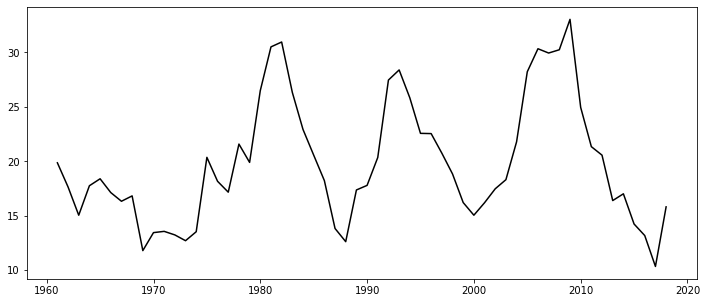

In [10]:
fig, ax = plt.subplots(figsize=[12, 5])
_ = ax.plot(egy, color='k')

Well, it seems like it is not clear whether there is any seasonality or trend. 
Below we try the KPSS test:

In [11]:
sm.tsa.stattools.kpss(egy)[1]

/Users/zhiyzuo/.virtualenvs/py3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


0.1

This says that we fail to reject the null hypothesis that this time series is stationary

## Autocorrelation

Let's take a look at autocorrelation then

/Users/zhiyzuo/.virtualenvs/py3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


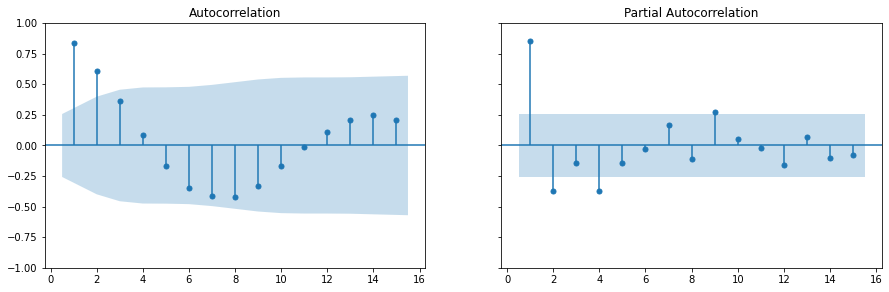

In [12]:
# the shaded region is the 95% CI
fig, (ax_acf, ax_pacf) = plt.subplots(figsize=[15, 4.5], ncols=2, sharey=True)
_ = sm.graphics.tsa.plot_acf(egy, lags=15, ax=ax_acf, zero=False)
_ = sm.graphics.tsa.plot_pacf(egy, lags=15, ax=ax_pacf, zero=False)

There might be some trend given the positive lag-1 autocorrelation but then the evidence seems weak based on the fast decrease of the next autocorrelations as well as the graphical approach. 
Meanwhile, when we are using annual data, there is no sessonality (unless we are talking about 12-year as a seasonal cycle, which is somwhat rare).

---

# Forecasting

Split the data:

In [13]:
N_train = int(0.8*egy.size)
N_test = egy.size - N_train
N_train, N_test

(46, 12)

In [14]:
# use iloc to slice the dataset
# .copy(deep=True) do a "deep copy" of the data slice
egy_train = egy.iloc[:N_train].copy(deep=True)
egy_test = egy.iloc[N_train:].copy(deep=True)

## AR model

Based on the partial autocorrelation diagram, we may try an order of 2 or 4:

In [15]:
# the first element in the `order` argument is `p` in AR(p)
ar2 = sm.tsa.SARIMAX(egy_train, order=(2, 0, 0), trend='c').fit(disp=False)
ar4 = sm.tsa.SARIMAX(egy_train, order=(4, 0, 0), trend='c').fit(disp=False)

## ARIMA

A rule of thumb for the order picking of (non-seasonal) ARIMA is to look at the ACF or PACF as above.
Specifically, the autocorrelation diagram is usually used to determine $q$, which in this case should be 2 while the partial autocorrelation one is helpful for setting $p$, which we might want to try 4.
Moreover, differencing is unnecessary since it is stationary, i.e., $d=0$ 

In [16]:
p, d, q = 4, 0, 2
arima1 = sm.tsa.SARIMAX(egy_train, order=(p, d, q), trend='c').fit(disp=False, maxiter=5e3)

/Users/zhiyzuo/.virtualenvs/py3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In practice, however, you may want to try a list of candidate values and pick the one with the best forecasting accuracy.

In [20]:
# randomly pick some paramete
p, d, q = 2, 0, 1
arima2 = sm.tsa.SARIMAX(egy_train, order=(p, d, q), trend='c', maxiter=1e3).fit(disp=False)

## Smoothing

While the time series seems to be stationary, there is likely some trend. After all, statistical test can be biased. In the meantime, there is likely no seasonality. In this case, Holt's method may suffice. We can follow our instinct.

In [21]:
# Use ETS model for exp smoothing methods.
holt = sm.tsa.ETSModel(egy_train, error='add', trend='add').fit(maxiter=1e3, disp=False)

## Performance

In [41]:
# use a dictionary to save the models
model_dict = {'AR(2)':ar2, 'AR(4)':ar4, 'ARIMA(4,0,2)':arima1, 'ARIMA(2,0,1)':arima2, 'Holt':holt}

In [44]:
## \t represents white space in tab
print('Model\t\t Train \t Test\t')
## compute MSE value for the training and testing part respectively
for mod_name, mod in model_dict.items():
    ## the mse function from sklearn.metrics
    mod_mse_fitted = metrics.mean_squared_error(y_pred=mod.fittedvalues, y_true=egy_train)
    mod_mse_forecast = metrics.mean_squared_error(y_pred=mod.forecast(N_test),
                                                  y_true=egy_test)
    ## use string formatter to print out the values neatly
    ## if add extra space if the model names are not the two long ones (ARIMA)
    if 'ARIMA' in mod_name:
        print('%s\t %.3f\t %.3f'%(mod_name, np.sqrt(mod_mse_fitted), np.sqrt(mod_mse_forecast)))
    else:
        print('%s\t %.3f\t %.3f'%(mod_name+'\t', np.sqrt(mod_mse_fitted), np.sqrt(mod_mse_forecast)))

Model		 Train 	 Test	
AR(2)		 2.740	 5.250
AR(4)		 2.593	 4.230
ARIMA(4,0,2)	 2.593	 4.167
ARIMA(2,0,1)	 2.659	 4.326
Holt		 3.032	 13.740


Our hand-picked ARIMA model works the best!

## Visualization (Optional)

In [45]:
kargs_dict = {'AR(2)': {'ls': 'dashed', 'color': 'r'},
              'AR(4)': {'ls': 'dashed', 'color': 'g'},
              'ARIMA(4,0,2)': {'ls': 'dotted', 'color': 'r'},
              'ARIMA(2,0,1)': {'ls': 'dotted', 'color': 'g'},
              'Holt': {'ls': '-.', 'color': 'navy'}}

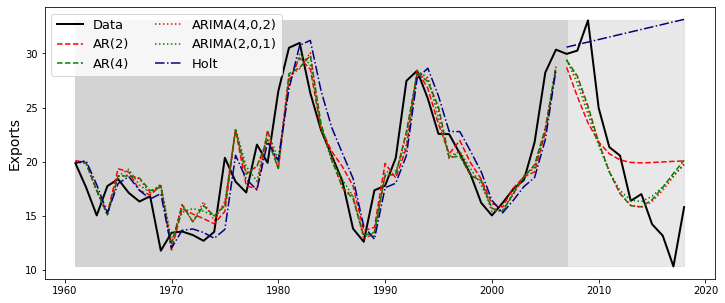

In [46]:
fig, ax = plt.subplots(figsize=[12, 5])
ax.plot(egy.index, egy.values,
        linestyle='-', linewidth=2,
        label='Data', color='k')
## plot each model separately
for mod_name, mod in model_dict.items():
    ## this is the code for line plot
    ax.plot(egy_train.index, mod.fittedvalues, **kargs_dict[mod_name])
    ax.plot(egy_test.index, mod.forecast(N_test), label=mod_name, **kargs_dict[mod_name])
## set up y-label
ax.set_ylabel('Exports', fontsize=14)
## these two `fill_betweenx` is for making different background colors for train/test
ax.fill_betweenx(np.linspace(egy.values.min(), egy.values.max()),
                 egy.index[0], egy.index[N_train], color='lightgray')
ax.fill_betweenx(np.linspace(egy.values.min(), egy.values.max()),
                 egy.index[N_train], egy.index[-1], color='lightgray', alpha=0.5)
## show legend
_ = ax.legend(prop={'size': 13}, ncol=2)

Visualize the testing data part only

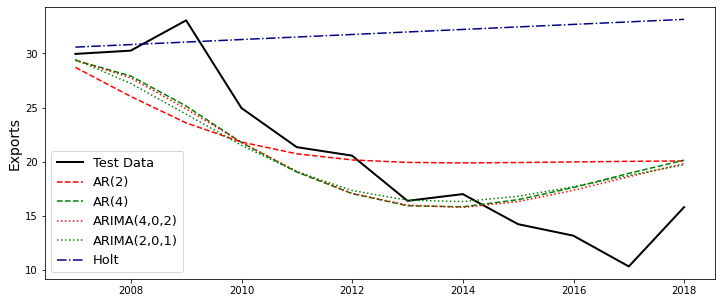

In [47]:
fig, ax = plt.subplots(figsize=[12, 5])
## plot the ground truth in solid line
ax.plot(egy_test.index, egy_test.values,
        linestyle='-', linewidth=2,
        label='Test Data', color='k')
## only forecasting for held-out test data for the three models
for mod_name, mod in model_dict.items():
    ax.plot(egy_test.index, mod.forecast(N_test), label=mod_name, **kargs_dict[mod_name])
## Set a y-label
ax.set_ylabel('Exports', fontsize=14)
## show the legend
_ = ax.legend(prop={'size': 13})